# **Mini-projeto LSTM**
Grupo: Amanda Moraes, Luís Eduardo Alves, Tales Alves

## 📁 **Dependências**

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
#importing the libraries
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [ ]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

## 🎲 **Dados**

In [ ]:
#loading the dataset
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc (1).csv


In [ ]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [ ]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use

array([7520.  , 7459.11, 7584.15, ...,  378.  ,  378.  ,  370.  ])

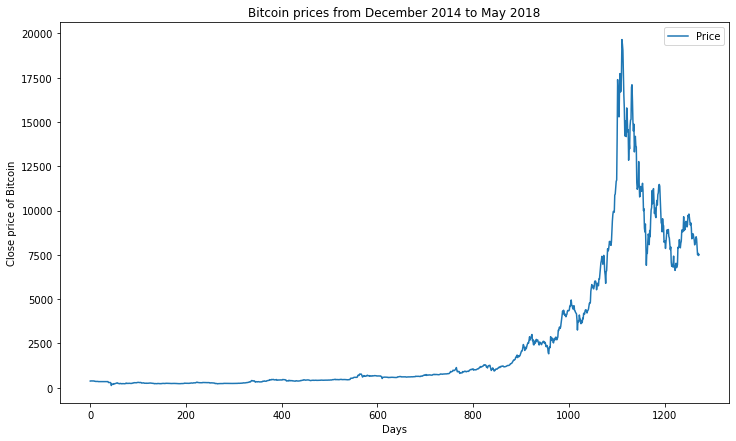

In [ ]:
#plotting the data
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Close price of Bitcoin')
plt.plot(np.flip(data_to_use).reshape(-1, 1), label='Price')
plt.legend()
plt.show()

## 🐘 **Datasets, LSTM e variação de parâmetros**

### Variação da quantidade de unidades da camada LSTM

#### 100 unidades

##### Datasets de treino e teste

In [ ]:
dataset = np.flip(data_to_use) #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

##### Definição de modelo e treinamento

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
15/15 [==============================] - 3s 43ms/step - loss: 0.0012 - val_loss: 0.1369
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0911
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0639
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 6.3411e-04 - val_loss: 0.0405
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 3.8037e-04 - val_loss: 0.0225
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 2.4309e-04 - val_loss: 0.0115
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 1.5255e-04 - val_loss: 0.0059
Epoch 8/20
15/15 [==============================] - 0s 6ms/step - loss: 7.9362e-05 - val_loss: 0.0036
Epoch 9/20
15/15 [==============================] - 0s 7ms/step - loss: 4.8015e-05 - val_loss: 0.0034
Epoch 10/20
15/15 [==============================] - 0s 5ms/step - loss: 4.8950e-05 - val_los

##### Avaliação

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 42.71460407218855
Train Root Mean Squared Error: 87.81133506831694
Test Mean Absolute Error: 917.3674551221989
Test Root Mean Squared Error: 1321.254349601832


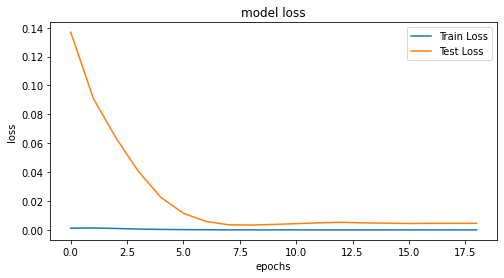

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

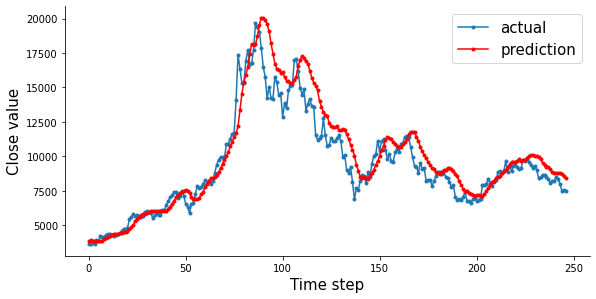

In [ ]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', marker='.', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
print(Y_test.shape, test_predict.shape)

(1, 247) (247, 1)


#### 200 unidades

##### Datasets de treino e teste

In [ ]:
dataset = np.flip(data_to_use) #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

##### Definição de modelo e treinamento

In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 8.5539e-04 - val_loss: 0.0933
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0527
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 5.9481e-04 - val_loss: 0.0287
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 2.0123e-04 - val_loss: 0.0099
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 9.9709e-05 - val_loss: 0.0039
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 4.4207e-05 - val_loss: 0.0035
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 3.1001e-05 - val_loss: 0.0042
Epoch 8/20
15/15 [==============================] - 0s 8ms/step - loss: 3.0959e-05 - val_loss: 0.0042
Epoch 9/20
15/15 [==============================] - 0s 9ms/step - loss: 2.8771e-05 - val_loss: 0.0041
Epoch 10/20
15/15 [==============================] - 0s 9ms/step - loss: 2.9621e-05 -

##### Avaliação

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 43.63762234507806
Train Root Mean Squared Error: 88.42004327970014
Test Mean Absolute Error: 867.7818901414499
Test Root Mean Squared Error: 1243.777515161593


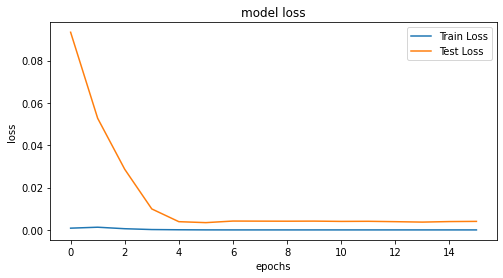

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

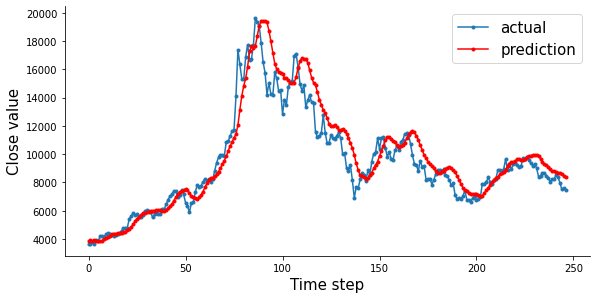

In [ ]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', marker='.', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Variação do tamanho da janela de histórico

#### Janela de 14 dias

##### Datasets de treino e teste

In [ ]:
dataset = np.flip(data_to_use) #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

##### Definição de modelo e treinamento

In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
15/15 [==============================] - 3s 66ms/step - loss: 5.6158e-04 - val_loss: 0.0546
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0115
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.4424e-04 - val_loss: 0.0062
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 5.9931e-05 - val_loss: 0.0119
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 5.3857e-05 - val_loss: 0.0066
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 4.5762e-05 - val_loss: 0.0073
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 4.8002e-05 - val_loss: 0.0063
Epoch 8/20
15/15 [==============================] - 0s 10ms/step - loss: 4.4637e-05 - val_loss: 0.0071
Epoch 9/20
15/15 [==============================] - 0s 8ms/step - loss: 5.1876e-05 - val_loss: 0.0063
Epoch 10/20
15/15 [==============================] - 0s 8ms/step - loss: 4.2241e-05

##### Avaliação

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 99.50118130507114
Train Root Mean Squared Error: 129.80220316211546
Test Mean Absolute Error: 1113.1023492110503
Test Root Mean Squared Error: 1485.3049731290614


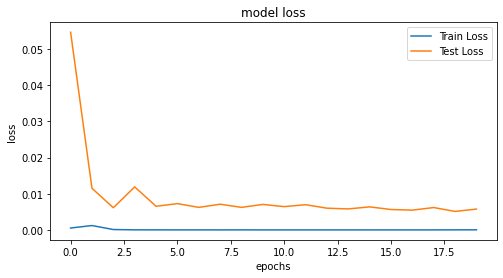

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

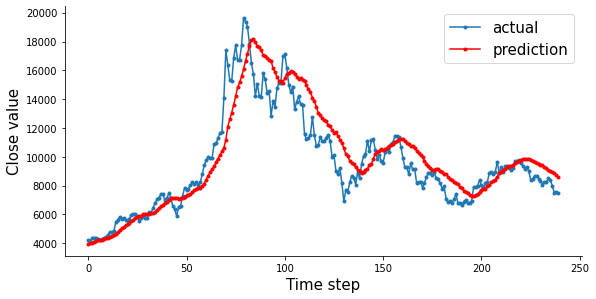

In [ ]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', marker='.', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#### Janela de 4 dias

##### Datasets de treino e teste

In [ ]:
dataset = np.flip(data_to_use) #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 4
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

##### Definição de modelo e treinamento

In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
15/15 [==============================] - 5s 45ms/step - loss: 0.0014 - val_loss: 0.1545
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.1160
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0909
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 8.5955e-04 - val_loss: 0.0645
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 6.2912e-04 - val_loss: 0.0425
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 4.6665e-04 - val_loss: 0.0263
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 2.8503e-04 - val_loss: 0.0144
Epoch 8/20
15/15 [==============================] - 0s 9ms/step - loss: 1.6752e-04 - val_loss: 0.0071
Epoch 9/20
15/15 [==============================] - 0s 9ms/step - loss: 8.6618e-05 - val_loss: 0.0034
Epoch 10/20
15/15 [==============================] - 0s 8ms/step - loss: 5.0477e-05 - val_los

##### Avaliação

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 32.66346162977698
Train Root Mean Squared Error: 72.02436664930052
Test Mean Absolute Error: 737.0257022820825
Test Root Mean Squared Error: 1101.5036506996871


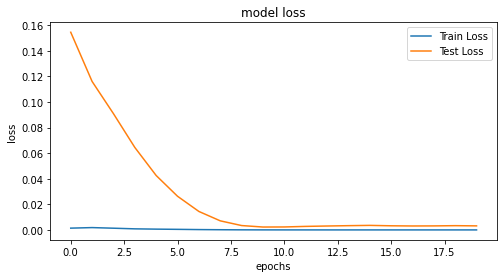

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

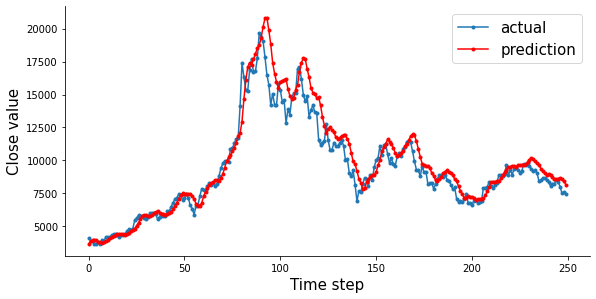

In [ ]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', marker='.', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## 📕 **Resumo**

| Parâmetros variados | Valores considerados |
|--- |--- |
| Quantidade de unidades da camada LSTM | [ 100, 200 ] |
| Tamanho da janela de histórico | [ 4, 7, 14 ] |

---

| Parâmetros | Modelo 🥇 | Modelo 🥈 | Modelo 🥉 |
|--- |--- |--- |--- |
| Quantidade de unidades da camada LSTM | 200 | 100 | 200 |
| Tamanho da janela de histórico | 4 | 7 | 7 |
| Root MSE (sem norm.) | 72.01 | 87.80 | 88.42 |
| Test Loss (MSE) (com norm.) | 0.0032 | 0.0046 | 0.0041 |

---

| Tendências de ganhos de desempenho |
|--- |
|Redução da janela de histórico|
|Tamanho intermediário de quantidade de unidades na camada LSTM|

### Visualização dos dados e predições do melhor modelo

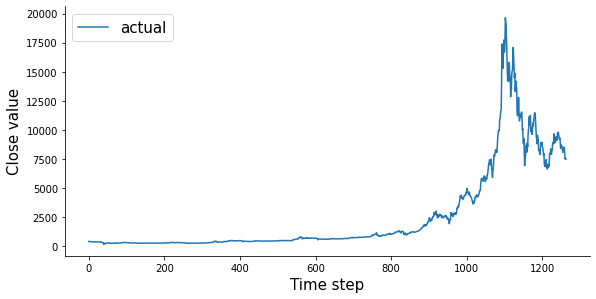

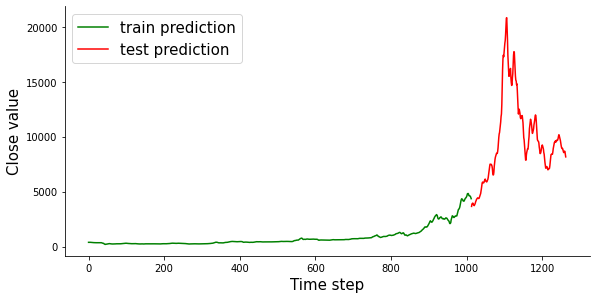

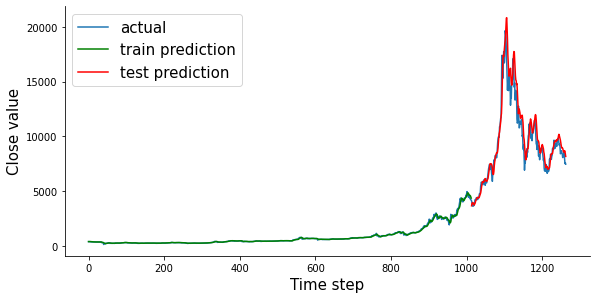

In [ ]:

plt.figure(figsize=(8,4))
plt.plot([x for x in range(Y_test.shape[1] + Y_train.shape[1])], np.concatenate((Y_train, Y_test), axis=1)[0], label="actual")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

plt.figure(figsize=(8,4))
plt.plot([x for x in range(Y_train.shape[1])], train_predict[:,0], 'g', label="train prediction")
plt.plot([x for x in range(Y_train.shape[1], Y_train.shape[1]+Y_test.shape[1])], test_predict[:,0], 'r', label="test prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

plt.figure(figsize=(8,4))
plt.plot([x for x in range(Y_test.shape[1] + Y_train.shape[1])], np.concatenate((Y_train, Y_test), axis=1)[0], label="actual")
plt.plot([x for x in range(Y_train.shape[1])], train_predict[:,0], 'g', label="train prediction")
plt.plot([x for x in range(Y_train.shape[1], Y_train.shape[1]+Y_test.shape[1])], test_predict[:,0], 'r', label="test prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## 🤔 **Conclusão**

Os resultados obtidos ao longo do projeto mostram o bom desempenho de redes LSTM na previsão de séries temporais. Devido à sua topologia e funcionamento, com células e 'gates' de fluxo, as LSTM conseguem abstrair e generalizar informações relevantes do histórico de dados para retornar predições precisas sobre dados futuros/desconhecidos.